In [1]:
import gymnasium as gym
from gymnasium import spaces
import pygame
from stable_baselines3 import PPO, DQN

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [2]:
class SnakeEnvHead(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, render_mode=None):
        super(SnakeEnvHead, self).__init__()
        self.grid_size = 20
        self.cell_size = 30
        self.action_space = spaces.Discrete(4)  # 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        self.observation_space = spaces.Box(low=0, high=1,
                                            shape=(self.grid_size, self.grid_size), dtype=np.int32)
        self.render_mode = render_mode
        self.window = None
        self.clock = None



    def reset(self, seed=None, options=None):
        self.snake = [(5, 5), (5, 5), (5, 5)]
        self.direction = 1
        self.food = self._place_food()
        self.done = False
        if self.render_mode == "human":
            self._init_render()
        return self._get_obs(), {}

    def _place_food(self):
        while True:
            food = (random.randint(0, 9), random.randint(0, 9))
            if food not in self.snake:
                return food

    def _get_obs(self):
        obs = np.zeros((self.grid_size, self.grid_size), dtype=np.int32)

        for x, y in self.snake[1:]:
            obs[y][x] = 1  # Body
        
        head_x, head_y = self.snake[0]
        obs[head_y][head_x] = 3  # 👈 Mark head as 3

        fx, fy = self.food
        obs[fy][fx] = 2  # Food is still 2

        return obs



    def step(self, action):
        if self.done:
            return self._get_obs(), 0, True, False, {}

        if abs(action - self.direction) == 2:
            action = self.direction

        self.direction = action

        dx = [0, 1, 0, -1]
        dy = [-1, 0, 1, 0]
        head_x, head_y = self.snake[0]
        new_head = (head_x + dx[action], head_y + dy[action])

        if (new_head in self.snake or
            not 0 <= new_head[0] < self.grid_size or
            not 0 <= new_head[1] < self.grid_size):
            self.done = True
            return self._get_obs(), -10, True, False, {}

        self.snake.insert(0, new_head)

        fx, fy = self.food
        old_dist = abs(head_x - fx) + abs(head_y - fy)
        new_dist = abs(new_head[0] - fx) + abs(new_head[1] - fy)

        self.steps = 0
        self.steps += 1

        if new_head == self.food:
            reward = 50
            self.food = self._place_food()
            self.steps = 0  
        else:
            reward = (old_dist - new_dist) * 0.5 - 0.2
            self.snake.pop()

        if self.steps >= 100:
            reward= -10
            self.done = True
            return self._get_obs(), reward, True, False, {}

################ Originele snake reward system  ###################################################################

#        if new_head == self.food:
#            reward = 10
#            self.food = self._place_food()
#        else:
#            reward = -0.1
#            self.snake.pop()
###############################################################################
        if self.render_mode == "human":
            self.render()
            

        return self._get_obs(), reward, False, False, {}

    def _init_render(self):
        pygame.init()
        self.window = pygame.display.set_mode(
            (self.grid_size * self.cell_size, self.grid_size * self.cell_size))
        pygame.display.set_caption("Snake AI")
        self.clock = pygame.time.Clock()

    def render(self):
        if self.window is None:
            self._init_render()

        self.window.fill((0, 0, 0))
        for x, y in self.snake:
            pygame.draw.rect(
                self.window,
                (0, 255, 0),
                pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
            )

        fx, fy = self.food
        pygame.draw.rect(
            self.window,
            (255, 0, 0),
            pygame.Rect(fx * self.cell_size, fy * self.cell_size, self.cell_size, self.cell_size)
        )

        pygame.display.flip()
        self.clock.tick(10)

    def close(self):
        if self.window:
            pygame.quit()


In [3]:
class SnakeEnvSMallerView(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, render_mode=None):
        super(SnakeEnvSMallerView, self).__init__()
        self.grid_size = 20
        self.cell_size = 30
        self.action_space = spaces.Discrete(4)  # 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 7, 7), dtype=np.float32)
        
        self.view_radius = 3  # de afstand rond de head die de agent ziet
        self.render_mode = render_mode
        self.window = None
        self.clock = None

    def reset(self, seed=None, options=None):
        self.snake = [(5, 5), (5, 5), (5, 5)]
        self.direction = 1
        self.food = self._place_food()
        self.done = False
        if self.render_mode == "human":
            self._init_render()
        return self._get_obs(), {}

    def _place_food(self):
        while True:
            food = (random.randint(0, 19), random.randint(0, 19))
            if food not in self.snake:
                return food


    def _get_obs(self):
        view_size = 3  # 3 op elke kant van de kop → 7x7
        obs = np.zeros((3, 7, 7), dtype=np.float32)

        head_x, head_y = self.snake[0]

        for dy in range(-view_size, view_size + 1):
            for dx in range(-view_size, view_size + 1):
                x = head_x + dx
                y = head_y + dy
                view_x = dx + view_size
                view_y = dy + view_size

                if 0 <= x < self.grid_size and 0 <= y < self.grid_size:
                    if (x, y) == self.snake[0]:
                        obs[2, view_y, view_x] = 1  # Head
                    elif (x, y) in self.snake[1:]:
                        obs[0, view_y, view_x] = 1  # Body
                    elif (x, y) == self.food:
                        obs[1, view_y, view_x] = 1  # Food

        return obs

    def step(self, action):
        if self.done:
            return self._get_obs(), 0, True, False, {}

        if abs(action - self.direction) == 2:
            action = self.direction

        self.direction = action

        dx = [0, 1, 0, -1]
        dy = [-1, 0, 1, 0]
        head_x, head_y = self.snake[0]
        new_head = (head_x + dx[action], head_y + dy[action])

        if (new_head in self.snake or
            not 0 <= new_head[0] < self.grid_size or
            not 0 <= new_head[1] < self.grid_size):
            self.done = True
            return self._get_obs(), -10, True, False, {}

        self.snake.insert(0, new_head)

        fx, fy = self.food
        old_dist = abs(head_x - fx) + abs(head_y - fy)
        new_dist = abs(new_head[0] - fx) + abs(new_head[1] - fy)

        self.steps = 0
        self.steps += 1

        if new_head == self.food:
            reward = 50
            self.food = self._place_food()
            self.steps = 0  
        else:
            reward = (old_dist - new_dist) * 0.5 - 0.2
            self.snake.pop()

        if self.steps >= 100:
            reward= -10
            self.done = True
            return self._get_obs(), reward, True, False, {}


        if self.render_mode == "human":
            self.render()
            

        return self._get_obs(), reward, False, False, {}

    def _init_render(self):
        pygame.init()
        self.window = pygame.display.set_mode(
            (self.grid_size * self.cell_size, self.grid_size * self.cell_size))
        pygame.display.set_caption("Snake AI")
        self.clock = pygame.time.Clock()

    def render(self):
        if self.window is None:
            self._init_render()

        self.window.fill((0, 0, 0))
        for x, y in self.snake:
            pygame.draw.rect(
                self.window,
                (0, 255, 0),
                pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
            )

        fx, fy = self.food
        pygame.draw.rect(
            self.window,
            (255, 0, 0),
            pygame.Rect(fx * self.cell_size, fy * self.cell_size, self.cell_size, self.cell_size)
        )
                        # === Highlight agent's view radius ===
        if self.snake:
            head_x, head_y = self.snake[0]
            r = self.view_radius
            for dy in range(-r, r+1):
                for dx in range(-r, r+1):
                    nx, ny = head_x + dx, head_y + dy
                    if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size:
                        pygame.draw.rect(
                            self.window,
                            (50, 50, 50),  # blauw = zichtgebied
                            pygame.Rect(nx * self.cell_size, ny * self.cell_size, self.cell_size, self.cell_size),
                            width=1  # alleen rand tekenen
                        )

        pygame.display.flip()
        self.clock.tick(10)

    def close(self):
        if self.window:
            pygame.quit()


In [4]:

class SnakeEnvSMallerViewWalled(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, render_mode=None):
        super(SnakeEnvSMallerViewWalled, self).__init__()
        self.grid_size = 20
        self.cell_size = 30
        self.action_space = spaces.Discrete(4)  # 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        self.observation_space = spaces.Box(low=0, high=1, shape=(4, 7, 7), dtype=np.float32)

        
        self.view_radius = 3  # de afstand rond de head die de agent ziet
        self.render_mode = render_mode
        self.window = None
        self.clock = None

    def reset(self, seed=None, options=None):
        self.snake = [(5, 5), (5, 5), (5, 5)]
        self.direction = 1
        self.food = self._place_food()
        self.done = False
        if self.render_mode == "human":
            self._init_render()
        return self._get_obs(), {}

    def _place_food(self):
        while True:
            food = (random.randint(0, 19), random.randint(0, 19))
            if food not in self.snake:
                return food


    def _get_obs(self):
        radius = self.view_radius
        head_x, head_y = self.snake[0]
        obs_size = 2 * radius + 1

        # Initialize 4-channel observation: wall, snake, food, head-direction
        obs = np.zeros((4, obs_size, obs_size), dtype=np.float32)

        for dy in range(-radius, radius + 1):
            for dx in range(-radius, radius + 1):
                nx, ny = head_x + dx, head_y + dy
                obs_x = dx + radius
                obs_y = dy + radius

                if not (0 <= nx < self.grid_size and 0 <= ny < self.grid_size):
                    obs[0, obs_y, obs_x] = 1  # wall
                elif (nx, ny) in self.snake:
                    obs[1, obs_y, obs_x] = 1  # snake body
                elif (nx, ny) == self.food:
                    obs[2, obs_y, obs_x] = 1  # food

        # Add head direction as a one-hot channel
        # 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        obs[3, radius, radius] = self.direction / 3.0  # normalize between 0 and 1

        return obs



    def step(self, action):
        if self.done:
            return self._get_obs(), 0, True, False, {}

        if abs(action - self.direction) == 2:
            action = self.direction

        self.direction = action

        dx = [0, 1, 0, -1]
        dy = [-1, 0, 1, 0]
        head_x, head_y = self.snake[0]
        new_head = (head_x + dx[action], head_y + dy[action])

        if (new_head in self.snake or
            not 0 <= new_head[0] < self.grid_size or
            not 0 <= new_head[1] < self.grid_size):
            self.done = True
            return self._get_obs(), -10, True, False, {}

        self.snake.insert(0, new_head)

        fx, fy = self.food
        old_dist = abs(head_x - fx) + abs(head_y - fy)
        new_dist = abs(new_head[0] - fx) + abs(new_head[1] - fy)

        self.steps = 0
        self.steps += 1

        if new_head == self.food:
            reward = 50
            self.food = self._place_food()
            self.steps = 0  
        else:
            reward = (old_dist - new_dist) * 0.5 - 0.2
            self.snake.pop()

        if self.steps >= 100:
            reward= -10
            self.done = True
            return self._get_obs(), reward, True, False, {}


        if self.render_mode == "human":
            self.render()
            

        return self._get_obs(), reward, False, False, {}

    def _init_render(self):
        pygame.init()
        self.window = pygame.display.set_mode(
            (self.grid_size * self.cell_size, self.grid_size * self.cell_size))
        pygame.display.set_caption("Snake AI")
        self.clock = pygame.time.Clock()

    def render(self):
        if self.window is None:
            self._init_render()

        self.window.fill((0, 0, 0))
        for x, y in self.snake:
            pygame.draw.rect(
                self.window,
                (0, 255, 0),
                pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
            )

        fx, fy = self.food
        pygame.draw.rect(
            self.window,
            (255, 0, 0),
            pygame.Rect(fx * self.cell_size, fy * self.cell_size, self.cell_size, self.cell_size)
        )
                        # === Highlight agent's view radius ===
        if self.snake:
            head_x, head_y = self.snake[0]
            r = self.view_radius
            for dy in range(-r, r+1):
                for dx in range(-r, r+1):
                    nx, ny = head_x + dx, head_y + dy
                    if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size:
                        pygame.draw.rect(
                            self.window,
                            (50, 50, 50),  # blauw = zichtgebied
                            pygame.Rect(nx * self.cell_size, ny * self.cell_size, self.cell_size, self.cell_size),
                            width=1  # alleen rand tekenen
                        )

        pygame.display.flip()
        self.clock.tick(10)

    def close(self):
        if self.window:
            pygame.quit()

In [5]:
class SnakeEnvTimeFrame(gym.Env):
    metadata = {"render_modes": ["human"]}
    def __init__(self, render_mode=None):
        super(SnakeEnvTimeFrame, self).__init__()
        self.grid_size = 20
        self.cell_size = 30
        self.action_space = spaces.Discrete(4)  # 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        self.observation_space = spaces.Box(
            low=0, high=2,
            shape=(3, self.grid_size, self.grid_size),
            dtype=np.int32
)
        self.render_mode = render_mode
        self.window = None
        self.clock = None
        self.obs_buffer = []    

    def reset(self, seed=None, options=None):
        self.snake = [(5, 5), (5, 5), (5, 5)]
        self.direction = 1
        self.food = self._place_food()
        self.done = False
        if self.render_mode == "human":
            self._init_render()
        return self._get_obs(), {}

    def _place_food(self):
        while True:
            food = (random.randint(0, 9), random.randint(0, 9))
            if food not in self.snake:
                return food

    def _get_obs(self):
        obs = np.zeros((self.grid_size, self.grid_size), dtype=np.int32)
        for x, y in self.snake:
            obs[y][x] = 1
        
        head_x, head_y = self.snake[0]
        obs[head_y][head_x] = 3  # 👈 Mark head as 3
        
        fx, fy = self.food
        obs[fy][fx] = 2
    
        self.obs_buffer.append(obs)
        if len(self.obs_buffer) > 3:
            self.obs_buffer.pop(0)
    
        while len(self.obs_buffer) < 3:
            self.obs_buffer.insert(0, np.zeros((self.grid_size, self.grid_size), dtype=np.int32))
    
        return np.array(self.obs_buffer)

    def step(self, action):
        if self.done:
            return self._get_obs(), 0, True, False, {}

        if abs(action - self.direction) == 2:
            action = self.direction

        self.direction = action

        dx = [0, 1, 0, -1]
        dy = [-1, 0, 1, 0]
        head_x, head_y = self.snake[0]
        new_head = (head_x + dx[action], head_y + dy[action])

        if (new_head in self.snake or
            not 0 <= new_head[0] < self.grid_size or
            not 0 <= new_head[1] < self.grid_size):
            self.done = True
            return self._get_obs(), -10, True, False, {}

        self.snake.insert(0, new_head)

        fx, fy = self.food
        old_dist = abs(head_x - fx) + abs(head_y - fy)
        new_dist = abs(new_head[0] - fx) + abs(new_head[1] - fy)

        self.steps = 0
        self.steps += 1

        if new_head == self.food:
            reward = 50
            self.food = self._place_food()
            self.steps = 0  
        else:
            reward = (old_dist - new_dist) * 0.5 - 0.2
            self.snake.pop()

        if self.steps >= 100:
            reward= -10
            self.done = True
            return self._get_obs(), reward, True, False, {}


        if self.render_mode == "human":
            self.render()
            

        return self._get_obs(), reward, False, False, {}

    def _init_render(self):
        pygame.init()
        self.window = pygame.display.set_mode(
            (self.grid_size * self.cell_size, self.grid_size * self.cell_size))
        pygame.display.set_caption("Snake AI")
        self.clock = pygame.time.Clock()

    def render(self):
        if self.window is None:
            self._init_render()

        self.window.fill((0, 0, 0))
        for x, y in self.snake:
            pygame.draw.rect(
                self.window,
                (0, 255, 0),
                pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
            )

        fx, fy = self.food
        pygame.draw.rect(
            self.window,
            (255, 0, 0),
            pygame.Rect(fx * self.cell_size, fy * self.cell_size, self.cell_size, self.cell_size)
        )

        pygame.display.flip()
        self.clock.tick(10)

    def close(self):
        if self.window:
            pygame.quit()


In [6]:


def test_model_with_plot(model,name, eval_env, num_episodes=20, render=False, max_steps_per_episode=300):

    total_rewards = []
    total_steps = []
    apples_per_episode = []

    best_score = float('-inf')  # Voor highscore

    for episode in range(num_episodes):
        obs, _ = eval_env.reset()
        done = False
        episode_reward = 0
        step_count = 0
        apples_eaten = 0
        prev_snake_len = len(eval_env.snake)

        while not done and step_count < max_steps_per_episode:
            if render:
                eval_env.render()

            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = eval_env.step(action)
            step_count += 1
            episode_reward += reward

            # Tel appel als lengte toeneemt
            current_snake_len = len(eval_env.snake)
            if current_snake_len > prev_snake_len:
                apples_eaten += 1
            prev_snake_len = current_snake_len

        total_rewards.append(episode_reward)
        total_steps.append(step_count)
        apples_per_episode.append(apples_eaten)

        
        if episode_reward > best_score:
            best_score = episode_reward

        #print(f"Episode {episode + 1}: Reward = {episode_reward:.2f}, Steps = {step_count}, Apples = {apples_eaten}")

    avg_reward = sum(total_rewards) / num_episodes
    avg_steps = sum(total_steps) / num_episodes
    total_apples = sum(apples_per_episode)
    highest_apples = max(apples_per_episode)

    return {
        "model_name": name,
        "avg_reward": avg_reward,
        "highest_reward": best_score,
        "avg_steps": avg_steps,
        "total_apples": total_apples,
        "highest_apples": highest_apples
    }


In [7]:

results = []

# Laad en test elk model


models_head = {
    "PPO_default_10M": PPO.load("ppo_snake_10M.zip"),
    "ppo_snake_head_1M": PPO.load("ppo_snake_head_1M.zip"),
    "ppo_snake_head_10M": PPO.load("ppo_snake_head_10M.zip"),
    "DQN_snake_head2M": DQN.load("DQN_snake_head2M.zip"),
}

models_timeframe = {    "ppo_snake_timeframe": PPO.load("ppo_snake_timeframe.zip"),
    "ppo_snake_timeframe_10M": PPO.load("ppo_snake_timeframe_10M.zip"),
    "ppo_snake_timeframe_2M_2.5lr": PPO.load("ppo_snake_timeframe_2M_2.5lr"),
    }

models_filtered_vision = {"dqn_snake_smallerview": DQN.load("dqn_snake_smallerview.zip"),
    "dqn_snake_smallerview_2M": DQN.load("dqn_snake_smallerview_2M.zip"),
    "ppo_snake_smallerview_2M_2.5learningrate": PPO.load("ppo_snake_smallerview_2M_2.5learningrate"),
    }

models_smallerview_wall = {    "ppo_smallerview_1M.zip": PPO.load("ppo_smallerview_1M.zip"),
    "ppo_smallerview_2M.zip": PPO.load("ppo_smallerview_2M.zip"),
    #"ppo_snake_smallerview_2M_2.5learningrate": PPO.load("ppo_snake_smallerview_2M_2.5learningrate"),
    #"ppo_snake_smallerview_5M_2.5learningrate": PPO.load("ppo_snake_smallerview_5M_2.5learningrate"),
    }

for name, model in models_head.items():
    env = SnakeEnvHead(render_mode=None)
    result = test_model_with_plot(model,name, eval_env=env, num_episodes=100, render=False)
    results.append(result)

for name, model in models_filtered_vision.items():
    env = SnakeEnvSMallerView(render_mode=None)
    result = test_model_with_plot(model,name, eval_env=env, num_episodes=100, render=False)
    results.append(result)

for name, model in models_smallerview_wall.items():
    env = SnakeEnvSMallerViewWalled(render_mode=None)
    result = test_model_with_plot(model,name, eval_env=env, num_episodes=100, render=False)
    results.append(result)

for name, model in models_timeframe.items():
    env = SnakeEnvTimeFrame(render_mode=None)
    result = test_model_with_plot(model,name, eval_env=env, num_episodes=1000, render=False)
    results.append(result)



# Zet in DataFrame
df_results = pd.DataFrame(results)
print(df_results)

c:\Users\Jaspe\.conda\envs\Pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Jaspe\.conda\envs\Pytorch\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


                                  model_name  avg_reward  highest_reward  \
0                            PPO_default_10M    -22.9560           138.9   
1                          ppo_snake_head_1M     14.6800           178.3   
2                         ppo_snake_head_10M    108.6800           473.0   
3                           DQN_snake_head2M     47.8070           238.6   
4                      dqn_snake_smallerview     -1.9400            90.8   
5                   dqn_snake_smallerview_2M      8.5440           146.1   
6   ppo_snake_smallerview_2M_2.5learningrate     18.7530           184.5   
7                     ppo_smallerview_1M.zip    -16.4540            47.1   
8                     ppo_smallerview_2M.zip    -13.6290            41.9   
9                        ppo_snake_timeframe     30.1778           378.7   
10                   ppo_snake_timeframe_10M    180.7875           669.9   
11              ppo_snake_timeframe_2M_2.5lr     67.0204           357.1   

    avg_ste

In [8]:
df_results

,model_name,avg_reward,highest_reward,avg_steps,total_apples,highest_apples
0,PPO_default_10M,-22.9560,138.9,168.140,29,3
1,ppo_snake_head_1M,14.6800,178.3,86.350,77,4
2,ppo_snake_head_10M,108.6800,473.0,69.340,251,10
3,DQN_snake_head2M,47.8070,238.6,100.470,142,5
4,dqn_snake_smallerview,-1.9400,90.8,16.750,25,2
5,dqn_snake_smallerview_2M,8.5440,146.1,21.330,45,3
6,ppo_snake_smallerview_2M_2.5learningrate,18.7530,184.5,42.430,72,4
7,ppo_smallerview_1M.zip,-16.4540,47.1,28.270,5,1
8,ppo_smallerview_2M.zip,-13.6290,41.9,15.000,3,1
9,ppo_snake_timeframe,30.1778,378.7,156.141,1284,8


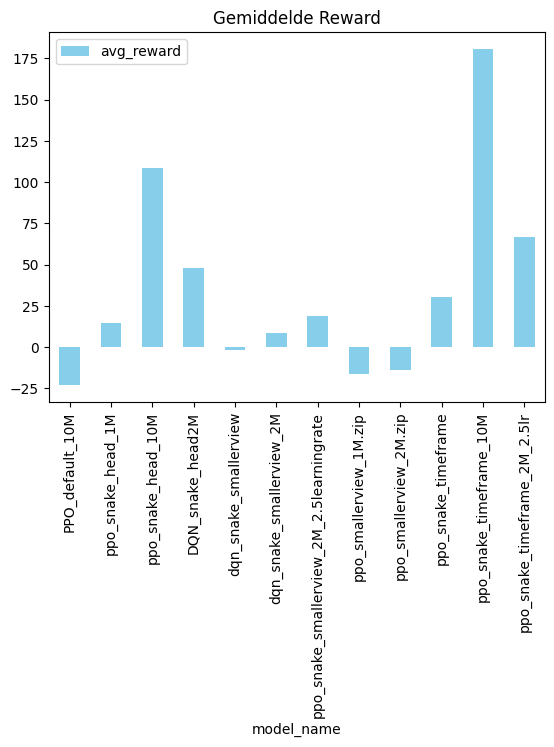

In [9]:
# Gemiddelde reward
df_results.plot.bar(x="model_name", y="avg_reward", color="skyblue", title="Gemiddelde Reward")

plt.show()

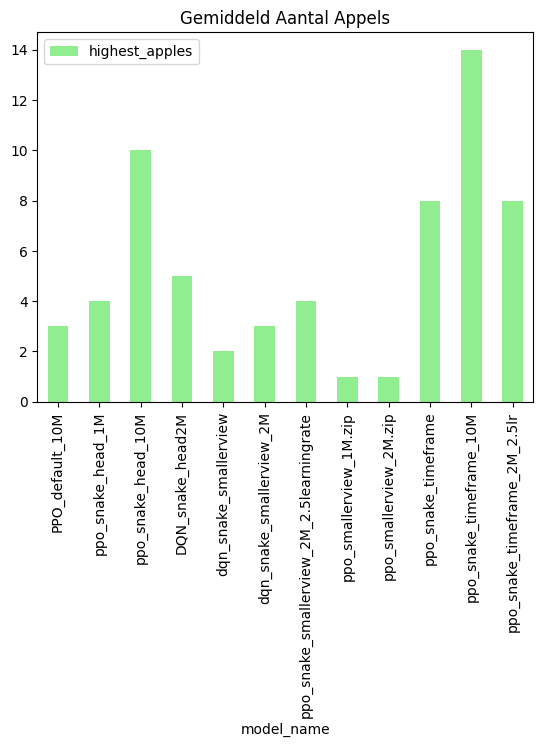

In [10]:
# Gemiddeld aantal appels
df_results.plot.bar(x="model_name", y="highest_apples", color="lightgreen", title="Gemiddeld Aantal Appels")

plt.show()

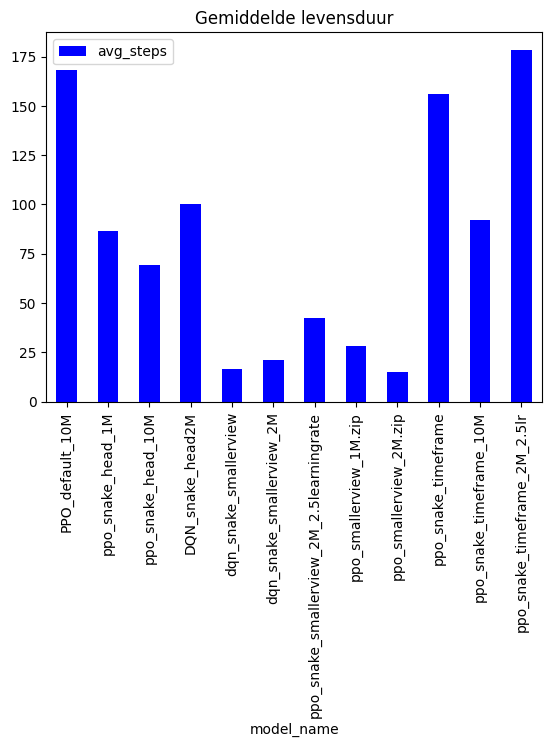

In [11]:
# Gemiddeld aantal appels
df_results.plot.bar(x="model_name", y="avg_steps", color="blue", title="Gemiddelde levensduur")


plt.show()